In [1]:
import pickle
import pandas as pd
import time
import numpy as np
import matplotlib as plt
import seaborn as sns

plt.style.use('seaborn')
%load_ext autotime

In [2]:
with open('final.pkl', 'rb') as f:
    df = pickle.load(f)

time: 39.8 ms


In [3]:
df.head()

,username,eye_color,hair,skin_tone,skin_type,skin_concerns,foundation_color,review,recommend,unhelpful,helpful,star
0,creecreex,Brown,Brunette,Deep,Normal,Cellulite,370,I have 370 and I got matched at Sephora. I lik...,1,0,14,100
1,Jijine,Brown,Black,Dark,Combination,Unknown,470,It is like my skin but better. very lightweigh...,1,0,5,100
2,bloodyblondie,Blue,Black,Porcelain,Dry,Blackheads,100,I was so nervous about trying this product bec...,1,0,5,100
3,miralanani,Brown,Brunette,Medium,Combination,Acne,270,This product was amazing! Just fell in love! T...,1,0,5,100
4,shaaliyah,Brown,Black,Deep,Combination,Acne,370,Since purchasing this foundation it's been my ...,1,0,38,100


time: 190 ms


In [4]:
df=df.drop_duplicates(['review'])

time: 33.7 ms


# Case 1: Y=Star Rating

## Vectorize and Set Up Data

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

time: 156 ms


In [6]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', max_df=0.6, token_pattern="\\b[a-z][a-z]+\\b")

time: 1.57 ms


In [7]:
cv_data=count_vectorizer.fit_transform(df['review'])

time: 1 s


In [8]:
X=cv_data
y=df['star']

time: 1.49 ms


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

time: 13.7 ms


## Imbalances

### Visualize

In [10]:
import matplotlib.pyplot as plt 

time: 927 µs


In [11]:
%matplotlib inline 

time: 19.3 ms


In [12]:
number_data=df.star.value_counts()

time: 5.76 ms


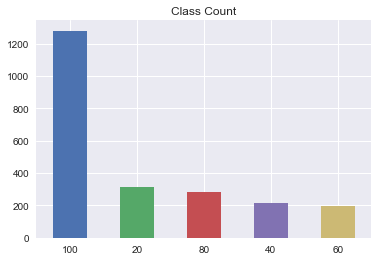

time: 1.06 s


In [13]:
number_data.plot(kind='bar', title='Class Count', rot=0);

### Oversample

In [14]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

time: 116 ms


In [15]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

time: 95.8 ms


In [16]:
Counter(y_resampled)

Counter({'80': 773, '100': 773, '20': 773, '40': 773, '60': 773})

time: 5.37 ms


## Model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, mean_squared_error

time: 124 ms


In [18]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None),
          LogisticRegression(C=0.1), naive_bayes.GaussianNB(),
         naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB()]
model_names = ["Random Forest", "Decision Tree",'Logistic', 'Naive-Bayes Gaussian',
              'Naive-Bayes Bernoulli', 'Naive-Bayes Multinomial']

time: 3.96 ms


In [19]:
acc_comparisons=[]
for clf, name in zip(models, model_names):
    print(name)
    clf.fit(X_resampled.toarray(), y_resampled)
    preds = clf.predict_proba(X_test.toarray())
    predictions = clf.predict(X_test.toarray())
    acc=accuracy_score(y_test,predictions)
    acc_comparisons.append((acc,name))
    print(acc)

Random Forest
0.5963003264417845
Decision Tree
0.4689880304678999
Logistic
0.6322089227421109
Naive-Bayes Gaussian
0.5527747551686616
Naive-Bayes Bernoulli
0.6583242655059848
Naive-Bayes Multinomial
0.6071817192600653
time: 2min 49s


[(0.4689880304678999, 'Decision Tree'), (0.5527747551686616, 'Naive-Bayes Gaussian'), (0.5963003264417845, 'Random Forest'), (0.6071817192600653, 'Naive-Bayes Multinomial'), (0.6322089227421109, 'Logistic'), (0.6583242655059848, 'Naive-Bayes Bernoulli')]


Text(0.5,1,'Accuracy Scores')

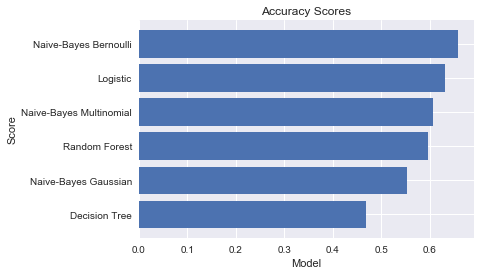

time: 788 ms


In [20]:
acc_comparisons.sort()
print(acc_comparisons)
acc_score=[score[0] for score in acc_comparisons]
acc_model_names=[score[1] for score in acc_comparisons]
plt.barh(acc_model_names,acc_score)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy Scores')
plt.legend(loc='best')

# Case 2: Y=Helpfulness

## Set Up Data

In [21]:
y2=df['helpful']

time: 4.57 ms


In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.4, random_state=42)

time: 30.9 ms


## Model

In [23]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

time: 81.3 ms


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
regress_models = [LinearRegression(), Ridge(), Lasso(alpha=0.5), LassoCV()]
regress_model_names = ["LinearRegression", "Ridge",'Lasso', 'LassoCV']

time: 2.34 ms


In [36]:
mse_comparisons=[]
for clf, name in zip(regress_models, regress_model_names):
    print(name)
    clf.fit(X_resampled.toarray(), y_resampled)
    predictions = clf.predict(X_test.toarray())
    mse=mean_squared_error(y_test,predictions)
    mse_comparisons.append((mse,name))
    print(mse)

LinearRegression
589.2463228452818
Ridge
539.6034335397524
Lasso
747.4051280144814
LassoCV
568.1184143251498
time: 18min 4s


No handles with labels found to put in legend.


[(539.6034335397524, 'Ridge'), (568.1184143251498, 'LassoCV'), (589.2463228452818, 'LinearRegression'), (747.4051280144814, 'Lasso')]


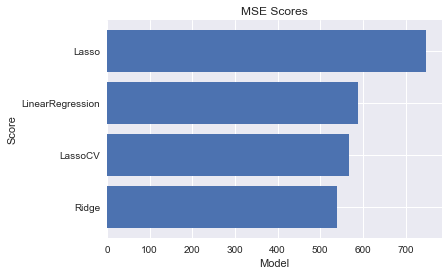

time: 199 ms


In [44]:
mse_comparisons.sort()
print(mse_comparisons)
mse_score=[score[0] for score in mse_comparisons]
mse_model_names=[score[1] for score in mse_comparisons]
plt.barh(mse_model_names,mse_score)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('MSE Scores')
plt.legend(loc='best')

In [27]:
ridge = Ridge()
ridge.fit(X_train2, y_train2)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

time: 278 ms


In [28]:
y_predict = ridge.predict(X_train2)
ridge.score(X_train2, y_train2)

0.997061128479812

time: 11.3 ms


In [29]:
y_predict_test = ridge.predict(X_test2)
ridge.score(X_test2, y_test2)

5.351755097970923e-07

time: 8.5 ms


## Predict Helpfulness

In [30]:
def prediction(review):
    '''
    1. count vectorize inputed review
    2. run through model
    '''
    vectorized_input=count_vectorizer.transform([review])
    helpfulness=ridge.predict(vectorized_input)
    return helpfulness

time: 5.29 ms


In [31]:
prediction('''First of all, what I absolutely adore about this foundation line is that I could actually find a perfect shade match. I actually use this foundation as a benchmark to gauge the colour match of other foundations that I want to try. Its medium coverage looks nice on my skin. I personally dont really like heavy foundations because they tend to make me look like I'm wearing a mask, so I do appreciate its natural looking finish. The pump packaging is brilliant. It makes application very easy and hygienic. I havent noticed any breakouts from using this product. However, I don't think it suits my oily, textured skin. Find that it doesn't give me that "pro-filter" it advertises. I've found that it doesn't look good when I apply it to my forehead because of my texture. It also does break down throughout the day and transfers a bit when I blot. The pigment separates around my nose and smile line area over time. Also, layering the product to become more full coverage tends to make my skin look cakey, so I just stick to applying a thin layer. Nonetheless, I have enjoyed my time with Fenty, but I think I'll be looking for other foundations after I'm done with this bottle.''')

array([37.88087224])

time: 55 ms


In [32]:
prediction('Hated it.')

array([8.76158109])

time: 3.32 ms


In [33]:
prediction("This foundation didn't work for me at all. Poor coverage and very cakey. Didn't last even 4 hours. The finish is horrible. Will not recommend this product.")

array([-5.38666326])

time: 5.84 ms


In [34]:
prediction("i didn't buy this product but id like to say my reason as to why.. its not animal cruelty free, and it doesn't have the symbol. It doesn't say it doesn't test on animals which disappoints me...such evil")

array([-7.39131292])

time: 6.56 ms
